<h2 style = "text-align: center;">Advanced Data Science for Traffic and Transportation Engineering</h2>

<h3 style = "text-align: center;">Determine the Position of Road Inspectors - Rijkswaterstaat</h3><br><br>

<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <h3 style = "text-align: left;">Group 3</h3>
        <ul>
            <li>Yiman Bao (5691648)</li>
            <li>Juan Camargo Fonseca (5834112)</li>
            <li>Tijmen Hoedjes (4959183)</li>
            <li>Max Lange (5169402)</li>
            <li>Wail Abdellaoui (5130654)</li>
        </ul>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="Images/TUDelft_logo.jpg" width="300"/>
     </div>
</div>

In [1]:
import data_filtering
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from datetime import datetime
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import networkx as nx

# 1 Probility of the incident

## 1.1 Import data and filter the data

In [2]:
#Extract subnetwork
highway_shapefile = 'Data/Shapefiles/Snelheid_Wegvakken.shp'
road_network = gpd.read_file(highway_shapefile)
road_network = road_network.to_crs("EPSG:4326")

In [3]:
path = 'Data/incidents19Q3Q4.csv'
df_incident = pd.read_csv(path)
df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
df_incident = data_filtering.filter_out(df_incident, road_network)

## 1.2 Kernel Density Estimation

Kernel Density Estimation (KDE) is a non-parametric statistical method used to estimate the probability density function (PDF) of a data set. It helps us convert discrete incident data points into incident probability densities on the map. 

In kernel density estimation, an important parameter is bandwidth. An excessively large bandwidth will make the probability density distribution more blurry, while a lower bandwidth will make it more difficult to obtain the probability by subsequent integration. Currently, we choose the averge road section in the road network as the bandwidth, which can help us to get the probability of the section.


In [13]:
#bandwidth = 0.05
bandwidth = np.mean(road_network['geometry'].length)
accident_coords = df_incident[['primaire_locatie_lengtegraad', 'primaire_locatie_breedtegraad']].values.T
# kde estimate
kde = gaussian_kde(accident_coords, bw_method=bandwidth)

C:\Users\86180\AppData\Local\Temp\ipykernel_14472\3692850434.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bandwidth = np.mean(road_network['geometry'].length)


In order to get the probility of each section, we use a simple way to save the code running time. We get the density at the midpoint of each road section from the KDE result and then multiply by road length to get probability. The result of it is also normalized after the simple integral.

In [14]:
road_network['Accident_Density'] = np.nan

for idx, row in road_network.iterrows():
    # Calculate the accident density at the midpoint of each road network segment
    density = kde([row.geometry.centroid.x, row.geometry.centroid.y])
    road_network.at[idx, 'Accident_Density'] = density[0]

road_network['Unnormalized_Probability'] = road_network['Accident_Density'] * road_network['geometry'].length
road_network['Normalized_Probability'] = road_network['Unnormalized_Probability'] / sum(road_network['Unnormalized_Probability'])

C:\Users\86180\AppData\Local\Temp\ipykernel_14472\204063085.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_network['Unnormalized_Probability'] = road_network['Accident_Density'] * road_network['geometry'].length


The result is shown as heatmap.

d:\anaconda\envs\geospatial\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


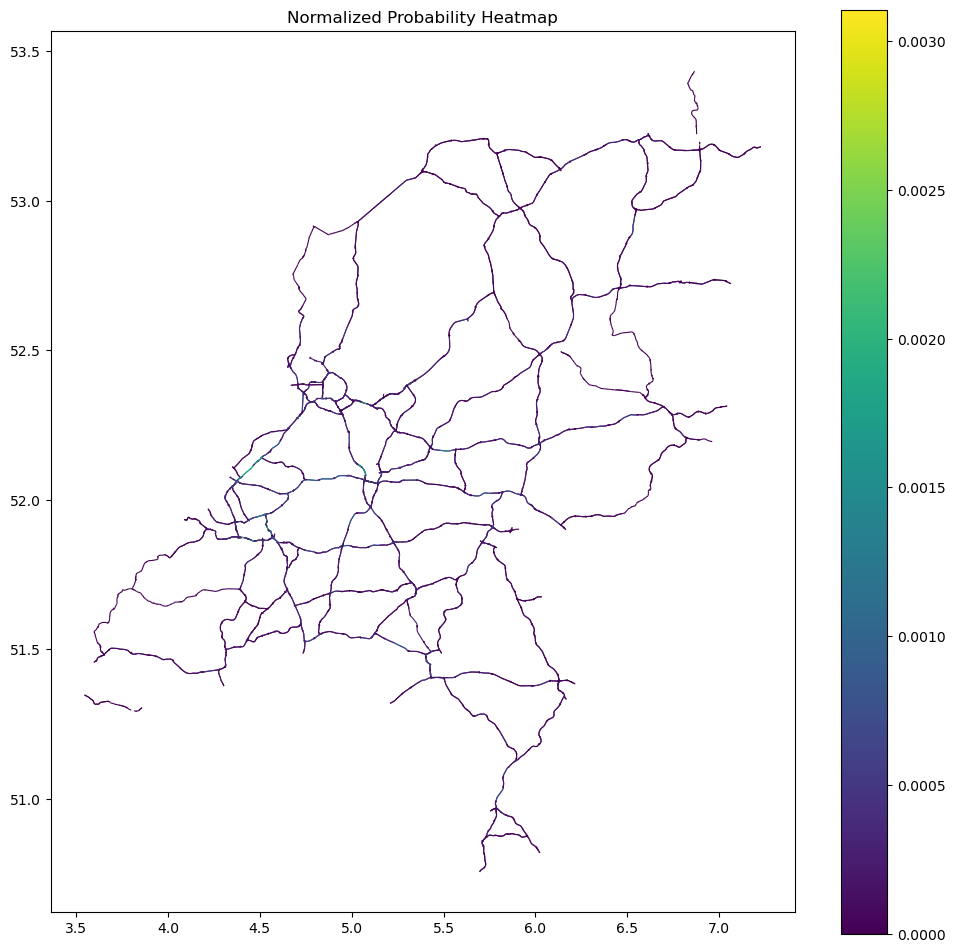

In [15]:
heatmap_gdf = road_network[['geometry', 'Normalized_Probability']].copy()
fig, ax = plt.subplots(figsize=(12, 12))
cmap = 'viridis'  
heatmap_gdf.plot(column='Normalized_Probability', cmap=cmap, linewidth=0.8, ax=ax, legend=True)
plt.title('Normalized Probability Heatmap')
plt.show()

After calculating the probabilities of the row-sections, these probabilities have been assigned to a graph to make sure the algorithm works well.

At first, as shown in the code below, the start and end node has been defined and after that each start and end node has been added to a previously created graph.

In [16]:
G_NL2 = nx.Graph()

for index, row in road_network.iterrows():

    line = row.geometry

    start_node = line.coords[0]
    end_node = line.coords[-1]

    G_NL2.add_node(start_node)
    G_NL2.add_node(end_node)

    G_NL2.add_edge(start_node, end_node, geometry=line, weight = row['Normalized_Probability'])
print(f"Number of nodes: {G_NL2.number_of_nodes()}")
print(f"Number of edges: {G_NL2.number_of_edges()}")

Number of nodes: 13382
Number of edges: 13945


After assigning the start and end node, there has been created a adjacency matrix which gives the probabilities between every node created in the graph. So, the arcs between these nodes are road sections which means that each row in the adjacency matrix represents a node. For example, if at the road section between node A and D the probability is 1.5e-6 for getting an accident, in (1, 4) of the matrix the value will be 1.5e-6.

And now, there has been applied an algorithm to assign the probabilities to the right node. With the np.count_nonzero() function, there has been calculated which nodes have just one row-section connection with another node and the number of these nodes has been assigend to a list. The columns where these 'one-row values' are lying in, have been multiplied with 2. After that, there has been writen a statement which contains that if a row is in the list which contains the numbers of the nodes with just one row-section connection, there has been added a 0 to the weights list. The weight list is a list with the total probabilities of each row. However, if a row is not in the 'just one row-section'-list there has been added the sum of that row divided by 2. 

So, after applying this algorithm, there has been created a total weight list with all the probabilities of each node to make a map for the algorithm.

In [17]:
amatrix = nx.adjacency_matrix(G_NL2).todense()
copy_amatrix = amatrix.copy()

zeros_pos = []
node_weights = []


for i,row in enumerate(copy_amatrix):
    nonzero = np.count_nonzero(row)
    if nonzero == 1:
        zeros_pos.append(i)

# Duplicate column values in amatrix according to the number of zeros in the row
for i in zeros_pos:
    amatrix[:, i] *= 2

# If the row position is in zeros_pos, append zeros to the weigths, otherwise split the edges weight evenly
for i,row in enumerate(copy_amatrix):
    if i in zeros_pos:
        node_weights.append(0)
    else:
        node_weights.append(np.sum(row)/2)
        

In [ ]:
points_gdf

,id,geometry,probability
0,"(4.844908131481842, 51.82406722220649)","LINESTRING (4.84491 51.82407, 4.84503 51.82408...",0.000000
1,"(4.848139752838696, 51.8243437274991)","LINESTRING (4.84491 51.82407, 4.84503 51.82408...",0.000040
2,"(6.522433283203707, 52.71574704359681)","LINESTRING (6.52243 52.71575, 6.52251 52.71575...",0.000020
3,"(6.525519180563414, 52.715730973811944)","LINESTRING (6.52243 52.71575, 6.52251 52.71575...",0.000147
4,"(6.0496804857541315, 53.05946562179147)","LINESTRING (6.04968 53.05947, 6.04991 53.05957...",0.000094
...,...,...,...
13377,"(7.227444695154516, 53.180360160093755)","LINESTRING (7.22123 53.17897, 7.22168 53.17907...",0.000000
13378,"(4.295733946728136, 51.589267907094815)","LINESTRING (4.29573 51.58927, 4.29564 51.58910)",0.000000
13379,"(6.634857665505743, 53.20268639295503)","LINESTRING (6.63200 53.20429, 6.63247 53.20398...",0.000000
13380,"(4.900407206622851, 52.49271260721845)","LINESTRING (4.90041 52.49271, 4.90080 52.49285...",0.000000


# 2 Algorithm I

## 2.1 The basic idea

## The Algorithm: Marching Leaf Nodes
Having assigned the accidents to the nodes in our network, we now use these accidents counts as a representation for the probability that a accident occurs in our network. We do this by deviding the accident counts of all nodes by the total number of allocated accidents, so that the sum of all probabilities is 1.

For the allocation of inspector we have a few rules to which our algorithm must comply:
1. All nodes in the network must be within reach of an inspector according to the travel time limit
2. The total probability of the nodes allocated to a single inspector must be within a given limit
3. All nodes allocated to an inspector must reachable within the travel time limit from at least one of the allocated nodes

With these rules, the following algorithm for placing a single inspector was devised:
1. We start at a leaf node of the network (leaf node = only one connecting edge). This way we prevent inspectors being placed in such a way that some leaf nodes fall just outside the coverage of the inspectors, requiring an entire extra inspector just to cover that leaf node. Starting with the leafs eliminates this issue.
2. Look at the reachable neighbours (keeping in mind the travel direction) of the node. Select the closest one. Add this closest neighbour to the list of nodes coverered by the inspector.
3. Check if the sum of the probabilities of the inspector's nodes are below the set thershold, if so continue, if not go to 'finish inspector network'
4. Check if the the inspector's nodes are all reachable within the travel time limit from at least one of the nodes (for this dijkstra shortest path algorithm is used), if so continue, if not go to 'finish' inspector network.
5. It seems that all checks are satisfied, the neighbour node is definitly added to the inspectors nodes. This node takes over the role of the leaf node from step 1, and we go back to step 2 using this new node.
6. 'Finish inspector network'. One of the checks has failed, meaning the inspector's personal network is at capacity for either total probability or travel time. We remove the added neighbour node, as that caused one of the checks to fail. We also look which node in the inspector's node gives the most central placement, and save that location as the node to place the inspector at. A single inspector placement is made.

With this placement loop, we can go through the entire network. Once a inspector placement has been made, the nodes which that inspector covers are removed from the main network. This way once a new inspector placement is made it cannot consider already covered nodes. It also means that leaf nodes are constantly created, as removing nodes and edges from the network in this way always creates new leafes. Once going through all the existing leaf-nodes, we repeat the loop again with the newly created leaf nodes, and repeat this cycle until the entire network is covered.


## 2.1 Coding part

### 2.1.1 Convert road network to graph

In [21]:
# Convert data to node and edge GeoDataFrames containing only needed info
points = {'name': [], 'geometry': []}
edges = {'from': [], 'to': [], 'type': [], 'direction': [], 'name': [], 'geometry': []}

for _, row in road_network.iterrows():
    if row['JTE_ID_BEG'] not in points['name']:
        points['name'].append(row['JTE_ID_BEG'])
        points['geometry'].append(Point(row['geometry'].coords[0]))
    
    if row['JTE_ID_END'] not in points['name']:
        points['name'].append(row['JTE_ID_END'])
        points['geometry'].append(Point(row['geometry'].coords[-1]))
    
    edges['from'].append(row['JTE_ID_BEG'])
    edges['to'].append(row['JTE_ID_END'])
    edges['type'].append(row['BST_CODE'])
    edges['direction'].append(row['RIJRICHTNG'])
    edges['name'].append(row['STT_NAAM'])
    edges['geometry'].append(row['geometry'])

#points_gdf = gpd.GeoDataFrame(points)
edges_gdf = gpd.GeoDataFrame(edges)

NWB_Graph = nx.Graph()

for _, point in points_gdf.iterrows():
    NWB_Graph.add_node(point['name'], pos=point['geometry'].coords[0], probability=point['probability'])

already_connected = []
crossroads_id = 1
for index, edge in edges_gdf.iterrows():
    NWB_Graph.add_edge(edge['from'], edge['to'], geom=edge['geometry'], weight=edge['geometry'].length)

    if edge['type'] in ['AFR', 'OPR'] and index not in already_connected:
        to_connect = edges_gdf[edges_gdf['name'] == edge['name']]
        to_connect = to_connect[to_connect['type'].isin(['AFR', 'OPR'])]

        # Add a node
        x = []
        y = []
        # TODO: add check for if direction is 'H' / add functionality to deal with other directions than 'H'
        for _, i in to_connect.iterrows():
            x.append(i['geometry'].coords[-1][0])
            y.append(i['geometry'].coords[-1][1])
        x = np.sum(x) / len(to_connect)
        y = np.sum(y) / len(to_connect)
        NWB_Graph.add_node(crossroads_id, pos=(x, y), probability=0)

        # Connect all to nodes to new node
        for index, i in to_connect.iterrows():
            already_connected.append(index)
            NWB_Graph.add_edge(i['to'], crossroads_id, geom=None, weight=0)

        crossroads_id += 1

print(crossroads_id)
print(NWB_Graph.size())